In [1]:
import gzip, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from neurovlm.data import data_dir
from neurovlm.retrieval_resources import (
    _load_autoencoder, _load_specter, _load_dataframe,
    _load_latent_text, _load_latent_wiki, _proj_head_text_mse,
    _load_masker
)
import torch.nn.functional as F
import nibabel as nib
from nilearn.image import resample_to_img

masker = _load_masker()
df = _load_dataframe()
autoencoder = _load_autoencoder()
specter = _load_specter()
proj_head = _proj_head_text_mse()

There are adapters available but none are activated for the forward pass.


In [2]:
# Load neurovault
neurovault_data = torch.load(
    data_dir / "neurovault.pt", weights_only=False
)
df_neuro, df_pubs, _, neuro_clust, _, _, text_emb = neurovault_data.values()

df_neurovault = pd.read_csv("/Users/ryanhammonds/Downloads/neuro_vault_brain_to_text.csv")
df = pd.read_excel("/Users/ryanhammonds/Downloads/network_labelling.xlsx", sheet_name="generative_titles_neurovault")

df_pubs = df_pubs.sort_values(by="doi").reset_index(drop=True)
df = df.sort_values(by="doi").reset_index(drop=True)
assert (df["doi"] == df_pubs["doi"]).all()

text = (df_pubs["title"] + "[SEP]" + df_pubs["abstract"]).tolist()
text_gen = []
text_gen_networks = []
text_gen_regions = []
text_gen_cognition = []
text_gen_clinical = []
for i in df["brain_to_text_summary"]:

    s = i.split("\n")
    title = s[0]

    abstract = " ".join([j for j in s[1:] if not j.startswith("###") and j != ""])
    abstract = abstract.replace("**", "")
    abstract = abstract.replace("__", "")
    title = title.replace("**", "")
    title = title.replace("__", "")
    text_gen.append(title + "[SEP]" + abstract)

    # networks, regions, cognition, clinical
    # nets, reg, cog, clin = [i for i in s[4:] if not i.startswith("#") and i != ""]
    idx = [idx for idx in range(len(s)) if s[idx] in ["### Networks", "### Key Regions", "### Cognitive Functions", "### Clinical Relevance"]]
    start = idx
    end = idx[1:]
    end.append(len(s))
    assert len(idx) == 4

    text_gen_networks.append("".join(s[start[0]:end[0]][1:]))
    text_gen_regions.append("".join(s[start[1]:end[1]][1:]))
    text_gen_cognition.append("".join(s[start[2]:end[2]][1:]))
    text_gen_clinical.append("".join(s[start[3]:end[3]][1:]))

In [ ]:
def embed(text, fname):
    with torch.no_grad():
        emb_gen = specter(text)
    torch.save(emb_gen, fname)

embed(text, "emb.pt")
embed(text_gen, "emb_gen.pt")
embed(text_gen_networks, "emb_gen_networks.pt")
embed(text_gen_regions, "emb_gen_regions.pt")
embed(text_gen_cognition, "emb_gen_cognition.pt")
embed(text_gen_clinical, "emb_gen_clinical.pt")

In [3]:
norm = lambda i : F.normalize(i, dim=1)
text_true = norm(torch.load("emb.pt"))
text_gen = norm(torch.load("emb_gen.pt"))
text_gen_networks = norm(torch.load("emb_gen_networks.pt"))
text_gen_regions = norm(torch.load("emb_gen_regions.pt"))
text_gen_cognition = norm(torch.load("emb_gen_cognition.pt"))
text_gen_clinical = norm(torch.load("emb_gen_clinical.pt"))

In [4]:
def compare(true, gen, ref=None, n_samples=100):

    # Normalize
    A = true
    B = gen

    if ref is not None:
        A = (A - ref) #/ ref.std()
        B = (B - ref) #/ ref.std()

    A = F.normalize(A, dim=1)
    B = F.normalize(B, dim=1)

    # True similarity distribution
    sim = (A * B).sum(dim=1)

    # Null distribution: randomly shuffle pairs
    sim_rand = torch.zeros((n_samples, len(sim)))
    for i in range(n_samples):
        inds = torch.randperm(len(A))
        sim_rand[i] = (A[inds] * B).sum(dim=1)

    return sim, sim_rand

In [5]:
train, test, val = torch.load(data_dir / "pmids_split.pt", weights_only=False).values()

latent_text, pmids_latent_text = _load_latent_text()
latent_neuro, pmids_latent_neuro = torch.load(data_dir / "latent_neuro.pt", weights_only=False).values()

latent_text_train = latent_text[pd.Series(pmids_latent_text).isin(train)]
latent_neuro_train = latent_neuro[pd.Series(pmids_latent_neuro).isin(train)]
latent_neuro_train = latent_neuro_train / latent_neuro_train.norm(dim=1)[:, None]

In [ ]:
def text_to_img(text_norm):
    with torch.no_grad():
        # imgs_gen = autoencoder.encoder(
        #     torch.sigmoid(autoencoder.decoder(proj_head(text_norm)))
        # )
        imgs_gen = proj_head(text_norm)
        imgs_gen = F.normalize(imgs_gen, dim=1)
    return imgs_gen

def neurovault_select(imgs_gen):
    imgs = torch.zeros_like(imgs_gen)
    for i, doi in enumerate(df_pubs["doi"]):
        with torch.no_grad():
            # Encoded image
            img = autoencoder.encoder(torch.from_numpy(
                neuro_clust[np.where(df_neuro["doi"] == doi)[0]] > 0
            ).to(torch.float32))
            img_norm = F.normalize(img, dim=1)
            imgs[i] = img_norm[(img_norm @ imgs_gen[i]).argmax()]
    return imgs

In [ ]:
imgs_gen_all = text_to_img(text_gen) # text_gen* is specter embeddings
imgs_all = neurovault_select(imgs_gen_all)

imgs_gen_networks = text_to_img(text_gen_networks)
imgs_networks = neurovault_select(imgs_gen_networks)

imgs_gen_regions = text_to_img(text_gen_regions)
imgs_regions = neurovault_select(imgs_gen_regions)

imgs_gen_cognition = text_to_img(text_gen_cognition)
imgs_cognition = neurovault_select(imgs_gen_cognition)

imgs_gen_clinical = text_to_img(text_gen_clinical)
imgs_clinical = neurovault_select(imgs_gen_clinical)

imgs_gen_clinical = text_to_img(text_gen_clinical)
imgs_clinical = neurovault_select(imgs_gen_clinical)

In [8]:
with torch.no_grad():
    ref_text = proj_head(latent_text_train).mean(axis=0)
ref_neuro = latent_neuro_train.mean(axis=0).to("cpu")

In [9]:
sim_all, sim_rand_all = compare(imgs_gen_all, imgs_all, ref=ref_neuro, n_samples=1_000)
sim_networks, sim_rand_networks = compare(imgs_gen_networks, imgs_networks, ref=ref_neuro, n_samples=1_000)
sim_regions, sim_rand_regions = compare(imgs_gen_regions, imgs_regions, ref=ref_neuro, n_samples=1_000)
sim_cognition, sim_rand_cognition = compare(imgs_gen_cognition, imgs_cognition, ref=ref_neuro, n_samples=1_000)
sim_clinical, sim_rand_clinical = compare(imgs_gen_clinical, imgs_clinical, ref=ref_neuro, n_samples=1_000)

In [10]:
imgs_gen = text_to_img(text_true) # true text -> predicted image
imgs = neurovault_select(imgs_gen)
with torch.no_grad():
    sim, sim_rand = compare(imgs, imgs_gen, ref=ref_neuro, n_samples=1_000)

Text(0, 0.5, 'Cosine Similarity')

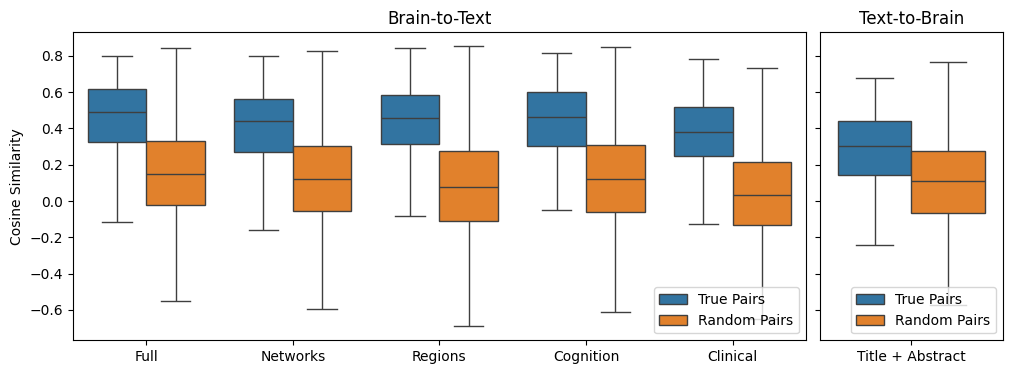

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

def paired_boxplot(
    true_vals_by_type: dict,
    gen_vals_by_type: dict,
    *,
    ax,
    order=("Full", "Networks", "Regions", "Cognition", "Clinical"),
    hue_order=("True Pairs", "Random Pairs"),
    showfliers=False,
    **kwargs,
):
    """
    Parameters
    ----------
    true_vals_by_type : dict[str, array-like]
        e.g. {"network": arr, "region": arr, ...}
    gen_vals_by_type : dict[str, array-like]
        same keys as true_vals_by_type
    ax : matplotlib.axes.Axes
    order : iterable[str]
        x-axis category order (Generation Type)
    hue_order : iterable[str]
        box order within each category
    showfliers : bool
    **kwargs : passed to seaborn.boxplot
    """
    rows = []
    for gtype in order:
        if gtype not in true_vals_by_type or gtype not in gen_vals_by_type:
            continue

        t = np.asarray(true_vals_by_type[gtype]).ravel()
        g = np.asarray(gen_vals_by_type[gtype]).ravel()

        rows.append(pd.DataFrame({"Generation Type": gtype, "Data": "True Pairs",   "Value": t}))
        rows.append(pd.DataFrame({"Generation Type": gtype, "Data": "Random Pairs", "Value": g}))

    df = pd.concat(rows, ignore_index=True)

    sns.boxplot(
        data=df,
        x="Generation Type",
        y="Value",
        hue="Data",
        order=[k for k in order if k in df["Generation Type"].unique()],
        hue_order=list(hue_order),
        ax=ax,
        showfliers=showfliers,
        **kwargs,
    )
    ax.set_xlabel("")
    ax.legend(loc="lower right")

    return df


fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    gridspec_kw={"width_ratios": [4, 1], "wspace": 0.03},
    sharey=True
)

_df = paired_boxplot(
    true_vals_by_type={
        "Full": sim_all,
        "Networks": sim_networks,
        "Regions": sim_regions,
        "Cognition": sim_cognition,
        "Clinical": sim_clinical,
    },
    gen_vals_by_type={
        "Full": sim_rand_all,
        "Networks": sim_rand_networks,
        "Regions": sim_rand_regions,
        "Cognition": sim_rand_cognition,
        "Clinical": sim_rand_clinical,
    },
    ax=axes[0],
    showfliers=False,
)

def _to_1d_numpy(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x).ravel()

sim_np      = _to_1d_numpy(sim)
sim_rand_np = _to_1d_numpy(sim_rand)

df = pd.DataFrame({
    "Generation Type": np.repeat("Title + Abstract", sim_np.size + sim_rand_np.size),
    "group": np.repeat(["True Pairs", "Random Pairs"], [sim_np.size, sim_rand_np.size]),
    "value": np.concatenate([sim_np, sim_rand_np]),
})

ax = sns.boxplot(data=df, x="Generation Type", y="value", showfliers=False, ax=axes[-1], hue="group")
ax.set_xlabel("")
ax.legend(loc="lower right")
axes[0].set_title("Brain-to-Text")
axes[1].set_title("Text-to-Brain")
axes[0].set_ylabel("Cosine Similarity")

In [ ]:
_df = _df[_df["Generation Type"] == "Full"]
_df.rename(columns={"Data": "group", "Value": "value"}, inplace=True)
_df["Generation Type"] = "Brain-to-Text"
df["Generation Type"] = "Text-to-Brain"

In [14]:
df_stack = pd.concat((df, _df))

Text(0.5, 1.0, 'Generative Latent Space Alignment')

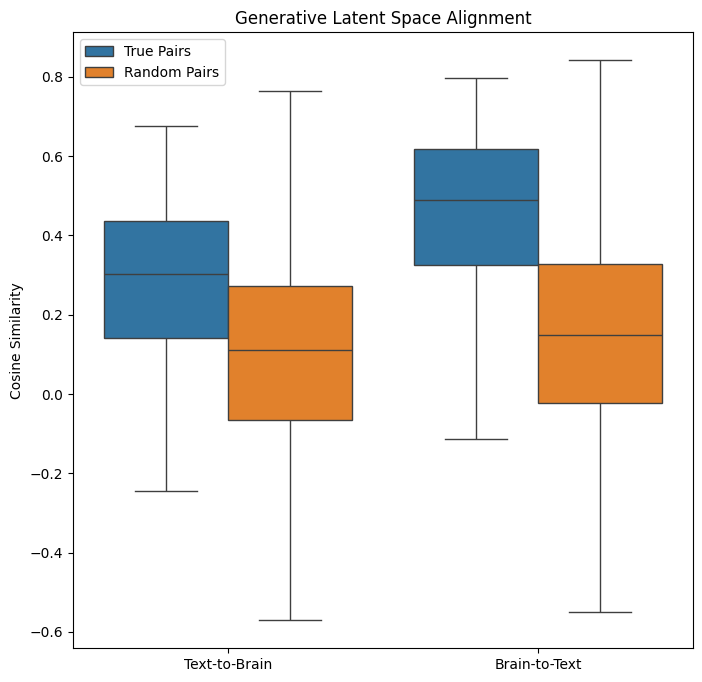

In [20]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_stack, x="Generation Type", y="value", hue="group", showfliers=False)
plt.xlabel("")
plt.ylabel("")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.title("Generative Latent Space Alignment")

In [ ]:
labels, imgs, text = torch.load(data_dir / "network_examples.pt", weights_only=False).values()

text = {
    "_".join([i.capitalize() for i in k.split("_")])
    .replace("o_O", "o-O").replace("_", " "): v.replace("(salience)", "")
    for k, v in text.items()
} # rename keys to match labels

assert all([k in labels for k in text.keys()])

In [222]:
text = {
    "Language": (
        "A left-dominant network supporting comprehension and production of language. "
        "Typically engaged by speech and text processing, semantic access, syntactic parsing, "
        "phonological processing, and verbal working memory during sentence-level integration."
    ),
    "Auditory": (
        "A network centered on primary and association auditory cortex that supports sound processing. "
        "Engaged by basic acoustic features (pitch, loudness, timbre), auditory scene analysis, "
        "speech perception at early stages, and detection of salient auditory events."
    ),
    "Default Mode": (
        "A network most active during internally focused cognition and relatively suppressed during demanding external tasks. "
        "Associated with episodic memory retrieval, self-referential thought, autobiographical reasoning, "
        "future simulation, theory of mind/social inference, and constructing coherent narratives/mental models."
    ),
    "Frontoparietal Control": (
        "A flexible 'executive control' network that coordinates goal-directed behavior across tasks. "
        "Supports adaptive cognitive control, task-set maintenance and switching, top-down attention, "
        "working memory manipulation, planning, and integrating information to guide decisions."
    ),
    "Attention": (
        "A set of networks (often including dorsal attention components) supporting externally directed attention. "
        "Engaged during visuospatial orienting, sustained attention, selection of task-relevant stimuli, "
        "top-down modulation of sensory areas, and attention-driven evidence accumulation."
    ),
    "Visual": (
        "A network spanning primary and higher-order visual cortex supporting perception and visual analysis. "
        "Engaged by visual feature processing (edges, motion, color), object/scene recognition, "
        "and visuospatial representations used for visually guided behavior and imagery."
    ),
    "Somatomotor": (
        "A network spanning primary motor and somatosensory cortex supporting movement and bodily sensation. "
        "Engaged by motor planning and execution, proprioception, tactile processing, "
        "and sensorimotor integration for coordinated action."
    ),
    "Cingulo-Opercular": (
        "A control/stability network (often linked to salience and sustained control) supporting maintenance of task goals over time. "
        "Engaged during performance monitoring, error/conflict detection, maintaining alertness, "
        "and coordinating stable control signals to keep behavior aligned with task demands."
    ),
}
text = {k: k + " [SEP] " + v for k, v in text.items()}

In [223]:
# Load network atlases
with gzip.open(data_dir / "networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

network_imgs = []
for k in networks.keys():
    for a in networks[k].keys():
        network_imgs.append((k, a, nib.Nifti1Image(networks[k][a]["array"], affine=networks[k][a]["affine"])))

networks = [i for i in network_imgs if i[0] not in ["UKBICA", "HCPICA"]]

networks_embed = torch.load(data_dir / "networks_emb.pt")

In [ ]:
# brain-to-text
# text-to-brain
with torch.no_grad():
    text_to_brain = torch.sigmoid(autoencoder.decoder(
        proj_head(F.normalize(specter([text[l] for l in labels]), dim=1))
    ))

text_to_brain = [masker.inverse_transform(i) for i in text_to_brain]

# with torch.no_grad():
#     text_to_brain_latent = F.normalize(proj_head(F.normalize(specter([text[l] for l in labels]), dim=1)), dim=1)
# idx = (text_to_brain_latent @ F.normalize(networks_embed, dim=1).T).argmax(dim=1)
# [(i, networks[i][1], str(l)) for (i, l) in zip(idx, labels)]

In [232]:
import textwrap
from nilearn.plotting import plot_stat_map
from nilearn.image import threshold_img

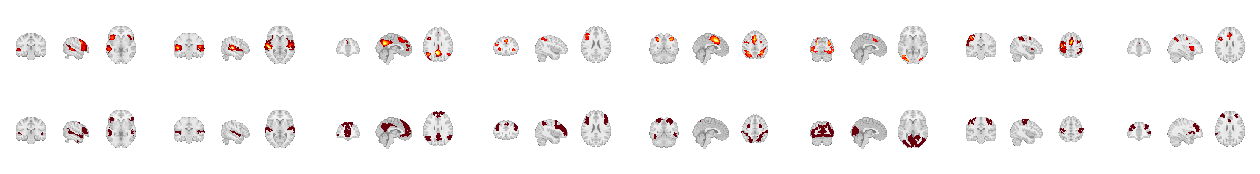

In [240]:
# fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(14, 16))
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 2))
wrap_width = 25

for i in range(8):
    # Text
    s = text[labels[i]].replace(" [SEP] ", "\n\n")
    s = "\n".join(textwrap.fill(line, width=wrap_width) for line in s.splitlines())

    # axes[0, i].axis("off")
    # axes[0, i].text(
    #     0.0, 1.0, s,
    #     transform=axes[0, i].transAxes,
    #     va="top", ha="left",
    #     #bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.8"),
    #     wrap=True,
    # )

    # Images
    thr_img = threshold_img(
        text_to_brain[i], "99%",
        cluster_threshold=25, two_sided=False, copy_header=True
    )

    true = plot_stat_map(imgs[i], colorbar=False, draw_cross=False, annotate=False, axes=axes[1, i], threshold=0.01, cmap="Reds")
    pred = plot_stat_map(thr_img, colorbar=False, draw_cross=False, annotate=False, axes=axes[0, i], threshold=0.01, cmap="hot",
                         cut_coords=true.cut_coords)

plt.savefig("/Users/ryanhammonds/Desktop/qualatative_decoding.svg")

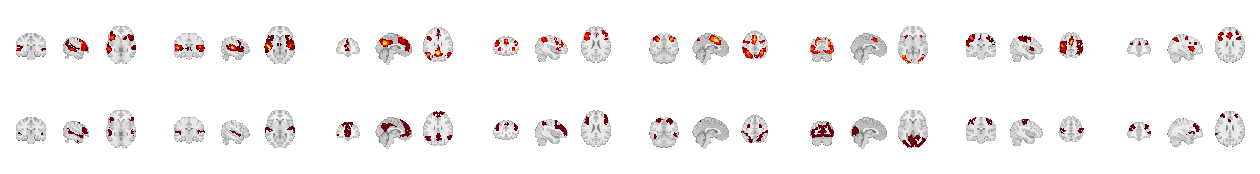

In [241]:
# fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(14, 16))
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 2))
wrap_width = 25

for i in range(8):
    # Text
    s = text[labels[i]].replace(" [SEP] ", "\n\n")
    s = "\n".join(textwrap.fill(line, width=wrap_width) for line in s.splitlines())

    # axes[0, i].axis("off")
    # axes[0, i].text(
    #     0.0, 1.0, s,
    #     transform=axes[0, i].transAxes,
    #     va="top", ha="left",
    #     #bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="0.8"),
    #     wrap=True,
    # )

    # Images
    thr_img = threshold_img(
        text_to_brain[i], "98%",
        cluster_threshold=25, two_sided=False, copy_header=True
    )

    true = plot_stat_map(imgs[i], colorbar=False, draw_cross=False, annotate=False, axes=axes[1, i], threshold=0.01, cmap="Reds")
    pred = plot_stat_map(thr_img, colorbar=False, draw_cross=False, annotate=False, axes=axes[0, i], threshold=0.01, cmap="hot",
                         cut_coords=true.cut_coords)

plt.savefig("/Users/ryanhammonds/Desktop/qualatative_decoding_2.svg")

In [242]:
clf = torch.load(data_dir / "concept_clf.pt")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ryanhammonds/projects/neurovlm/src/neurovlm/neurovlm_data/concept_clf.pt'